In [1]:
!pip install -q torch_snippets

In [2]:
!pip install torch_summary

In [3]:
!pip install fastcore==1.5.29

In [4]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchsummary import summary
from torch_snippets.torch_loader import Report

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Preprocessing

## Noise Function

In [5]:
def AddGaussianNoise(img, mean=0.0, std=0.8):
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, -1.0, 1.0)

def AddSaltPepperNoise(img_tensor, noise_ratio=0.4):

    img = img_tensor.numpy().squeeze() * 255
    img = img.astype(np.uint8)
    img = img.copy()

    row, col = img.shape
    num_pixels = row * col
    num_noisy = int(noise_ratio * num_pixels)

    # Add white pixels
    for _ in range(num_noisy // 2):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord, x_coord] = 255

    # Add black pixels
    for _ in range(num_noisy // 2):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord, x_coord] = 0

    noisy_img = torch.tensor(img / 255.0, dtype=torch.float32).unsqueeze(0)
    return noisy_img

## Pairing

In [6]:
class NoisyMNIST(Dataset):
    def __init__(self, dataset, noise_type=None):
        self.dataset = dataset
        self.noise_type = noise_type

    def __getitem__(self, index):
        clean_img, _ = self.dataset[index]

        if self.noise_type == "gaussian":
            noisy_img = AddGaussianNoise(clean_img)
        elif self.noise_type == "sap":
            noisy_img = AddSaltPepperNoise(clean_img)

        return noisy_img, clean_img

    def __len__(self):
        return len(self.dataset)

In [7]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [8]:
# Original MNIST
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
test_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

train_size = int(0.8*len(trn_ds))
val_size = len(trn_ds) - train_size
trn_ds, val_ds = random_split(trn_ds, [train_size, val_size])

In [9]:
batch_size = 128


trn_gaussian_ds = NoisyMNIST(trn_ds, noise_type="gaussian")
val_gaussian_ds = NoisyMNIST(val_ds, noise_type="gaussian")
test_gaussian_ds = NoisyMNIST(test_ds, noise_type="gaussian")

trn_gaussian_dl = DataLoader(trn_gaussian_ds, batch_size=batch_size, shuffle=True)
val_gaussian_dl = DataLoader(val_gaussian_ds, batch_size=batch_size, shuffle=False)
test_gaussian_dl = DataLoader(test_gaussian_ds, batch_size=batch_size, shuffle=False)


trn_sap_ds = NoisyMNIST(trn_ds, noise_type="sap")
val_sap_ds = NoisyMNIST(val_ds, noise_type="sap")
test_sap_ds = NoisyMNIST(test_ds, noise_type="sap")

trn_sap_dl = DataLoader(trn_sap_ds, batch_size=batch_size, shuffle=True)
val_sap_dl = DataLoader(val_sap_ds, batch_size=batch_size, shuffle=False)
test_sap_dl = DataLoader(test_sap_ds, batch_size=batch_size, shuffle=False)

In [10]:
# Print dataset lengths
print(f"\nTrain dataset length (gaussian): {len(trn_gaussian_ds)}")
print(f"Val dataset length (gaussian): {len(val_gaussian_ds)}")
print(f"Test dataset length (gaussian): {len(test_gaussian_ds)}")

print(f"\nTrain dataset length (salt & pepper): {len(trn_sap_ds)}")
print(f"Val dataset length (salt & pepper): {len(val_sap_ds)}")
print(f"Test dataset length (salt & pepper): {len(test_sap_ds)}")

# Print number of batches in each DataLoader
print(f"\nTrain dataloader batches (gaussian): {len(trn_gaussian_dl)}")
print(f"Val dataloader batches (gaussian): {len(val_gaussian_dl)}")
print(f"Test dataloader batches (gaussian): {len(test_gaussian_dl)}")

print(f"\nTrain dataloader batches (salt & pepper): {len(trn_sap_dl)}")
print(f"Val dataloader batches (salt & pepper): {len(val_sap_dl)}")
print(f"Test dataloader batches (salt & pepper): {len(test_sap_dl)}")


Train dataset length (gaussian): 48000
Val dataset length (gaussian): 12000
Test dataset length (gaussian): 10000

Train dataset length (salt & pepper): 48000
Val dataset length (salt & pepper): 12000
Test dataset length (salt & pepper): 10000

Train dataloader batches (gaussian): 375
Val dataloader batches (gaussian): 94
Test dataloader batches (gaussian): 79

Train dataloader batches (salt & pepper): 375
Val dataloader batches (salt & pepper): 94
Test dataloader batches (salt & pepper): 79


## Print Image

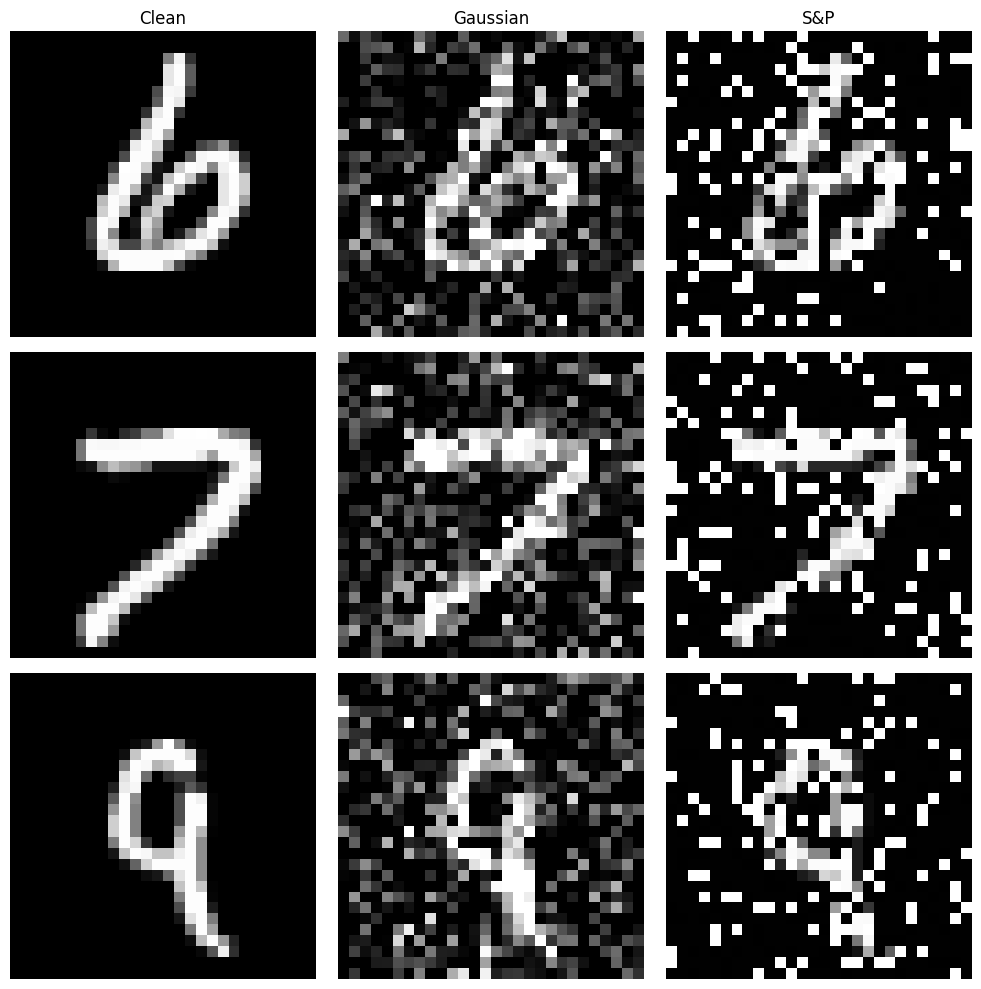

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

titles = ["Clean", "Gaussian", "S&P"]
for row in range(3):
    idx = np.random.randint(len(trn_ds))
    images = [
        trn_ds[idx][0],
        trn_gaussian_ds[idx][0],
        trn_sap_ds[idx][0]
    ]

    for col in range(3):
        img = images[col].squeeze(0)
        show(img, ax=axs[row][col], title=titles[col] if row == 0 else None)

for col in range(3):
    axs[0][col].set_title(titles[col], fontsize=12)

plt.tight_layout()
plt.show()


# Training and Testing

## Autoencoder

In [11]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.flatten = nn.Flatten()
        self.encoder_fc = nn.Linear(64*2*2, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 64*2*2)
        self.unflatten = nn.Unflatten(1,(64,2,2))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.encoder_fc(x)
        x = self.decoder_fc(z)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

## Gaussian Noise

### Latent_dim = 16

In [ ]:
model = ConvAutoEncoder(latent_dim=16).to(device)

In [ ]:
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Flatten: 1-2                           [-1, 256]                 --
├─Linear: 1-3                            [-1, 16]                  4,112
├─Linear: 1-4                            [-1, 256]                 4,352
├─Unflatten: 1-5                         [-1, 64, 2, 2]            --
├─Sequential: 1-6                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464


#### Training

In [12]:
def train_batch(noisy, clean, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(noisy)
    loss = criterion(output, clean)
    loss.backward()
    optimizer.step()
    return loss

In [13]:
@torch.no_grad()
def validate_batch(noisy, clean, model, criterion):
    model.eval()
    output = model(noisy)
    loss = criterion(output, clean)
    return loss

In [ ]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
num_epochs = 20
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_gaussian_dl)
    for ix, (noisy, clean) in enumerate(trn_gaussian_dl):
        loss = train_batch(noisy, clean, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_gaussian_dl)
    for ix, (noisy, clean) in enumerate(val_gaussian_dl):
        loss = validate_batch(noisy,clean, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 0.288  val_loss: 0.224  (58.13s - 1104.39s remaining)
EPOCH: 2.000  trn_loss: 0.183  val_loss: 0.153  (99.52s - 895.68s remaining)
EPOCH: 3.000  trn_loss: 0.142  val_loss: 0.135  (144.03s - 816.17s remaining)
EPOCH: 4.000  trn_loss: 0.128  val_loss: 0.124  (184.90s - 739.62s remaining)
EPOCH: 5.000  trn_loss: 0.120  val_loss: 0.117  (226.34s - 679.03s remaining)
EPOCH: 6.000  trn_loss: 0.114  val_loss: 0.114  (267.43s - 624.01s remaining)
EPOCH: 7.000  trn_loss: 0.111  val_loss: 0.110  (308.75s - 573.40s remaining)
EPOCH: 8.000  trn_loss: 0.108  val_loss: 0.108  (350.42s - 525.62s remaining)
EPOCH: 9.000  trn_loss: 0.107  val_loss: 0.106  (391.36s - 478.33s remaining)
EPOCH: 10.000  trn_loss: 0.105  val_loss: 0.105  (432.12s - 432.12s remaining)
EPOCH: 11.000  trn_loss: 0.104  val_loss: 0.104  (473.13s - 387.11s remaining)
EPOCH: 12.000  trn_loss: 0.103  val_loss: 0.105  (514.76s - 343.18s remaining)
EPOCH: 13.000  trn_loss: 0.102  val_loss: 0.104  (556.39s - 29

100%|██████████| 121/121 [00:00<00:00, 570.28it/s]


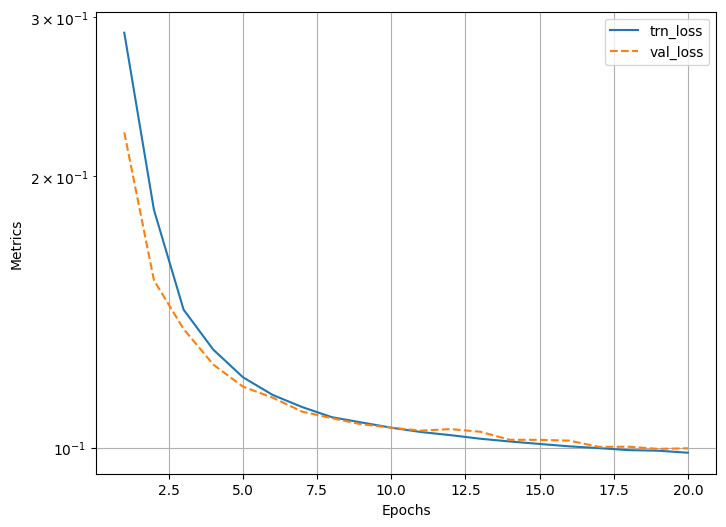

In [ ]:
log.plot_epochs(log=True)

#### Testing

In [14]:
@torch.no_grad()
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss, total_psnr, total_ssim = 0.0, 0.0, 0.0
    num_samples = 0

    for noisy, clean in test_loader:
        output = model(noisy)

        for i in range(noisy.size(0)):
            clean_img = clean[i].squeeze().cpu().numpy()
            output_img = output[i].squeeze().cpu().numpy()

            psnr_gaussian = psnr(clean_img, output_img)
            ssim_gaussian = ssim(clean_img, output_img, data_range=1.0)
            total_psnr += psnr_gaussian
            total_ssim += ssim_gaussian
            num_samples += 1

    print(f"Avg PSNR: {total_psnr / num_samples:.2f}")
    print(f"Avg SSIM: {total_ssim / num_samples:.4f}")

In [15]:
def visualize_denoising(model, test_loader, num_images=3):
    model.eval()
    noisy, clean = next(iter(test_loader))
    with torch.no_grad():
        output = model(noisy)

    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(noisy[i].squeeze().cpu(), cmap='gray')
        axs[0].set_title("Noisy")
        axs[1].imshow(output[i].squeeze().cpu(), cmap='gray')
        axs[1].set_title("Denoised")
        axs[2].imshow(clean[i].squeeze().cpu(), cmap='gray')
        axs[2].set_title("Ground Truth")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
test_model(model, test_gaussian_dl, criterion)

Avg PSNR: 16.63
Avg SSIM: 0.6663


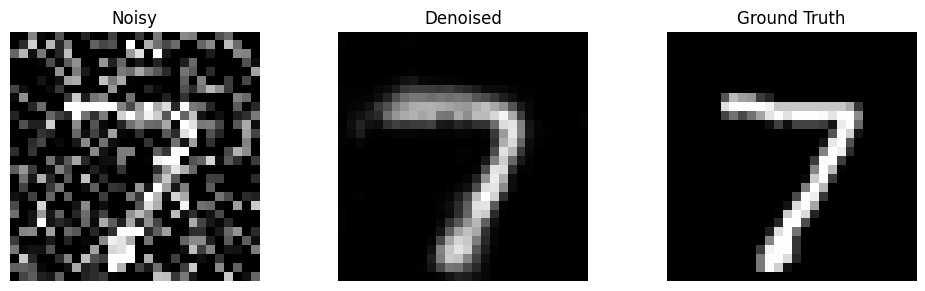

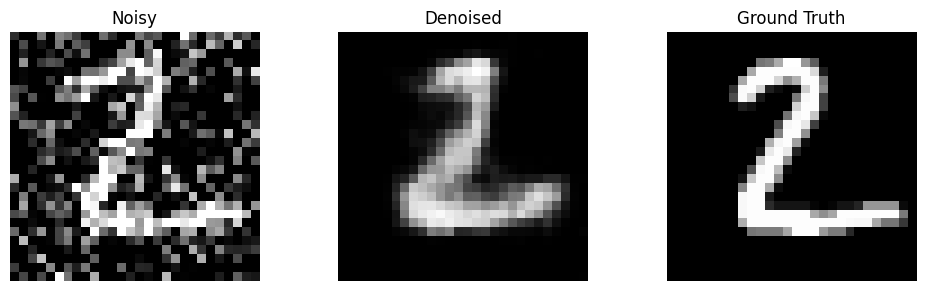

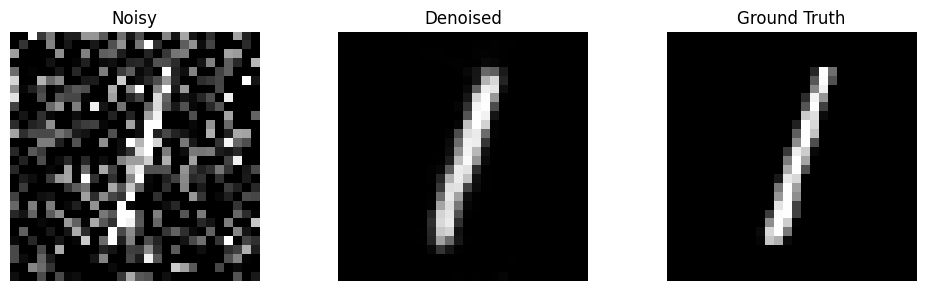

In [ ]:
visualize_denoising(model, test_gaussian_dl)

### Latent_dim = 8

In [ ]:
model = ConvAutoEncoder(latent_dim=8).to(device)

In [ ]:
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Flatten: 1-2                           [-1, 256]                 --
├─Linear: 1-3                            [-1, 8]                   2,056
├─Linear: 1-4                            [-1, 256]                 2,304
├─Unflatten: 1-5                         [-1, 64, 2, 2]            --
├─Sequential: 1-6                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464


In [ ]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
num_epochs = 20
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_gaussian_dl)
    for ix, (noisy, clean) in enumerate(trn_gaussian_dl):
        loss = train_batch(noisy, clean, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_gaussian_dl)
    for ix, (noisy, clean) in enumerate(val_gaussian_dl):
        loss = validate_batch(noisy,clean, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 0.306  val_loss: 0.212  (44.49s - 845.37s remaining)
EPOCH: 2.000  trn_loss: 0.187  val_loss: 0.171  (86.05s - 774.41s remaining)
EPOCH: 3.000  trn_loss: 0.155  val_loss: 0.145  (127.37s - 721.74s remaining)
EPOCH: 4.000  trn_loss: 0.137  val_loss: 0.132  (168.81s - 675.26s remaining)
EPOCH: 5.000  trn_loss: 0.128  val_loss: 0.125  (210.14s - 630.41s remaining)
EPOCH: 6.000  trn_loss: 0.122  val_loss: 0.120  (251.77s - 587.47s remaining)
EPOCH: 7.000  trn_loss: 0.118  val_loss: 0.116  (292.81s - 543.79s remaining)
EPOCH: 8.000  trn_loss: 0.114  val_loss: 0.113  (333.83s - 500.74s remaining)
EPOCH: 9.000  trn_loss: 0.112  val_loss: 0.111  (374.81s - 458.11s remaining)
EPOCH: 10.000  trn_loss: 0.110  val_loss: 0.109  (416.44s - 416.44s remaining)
EPOCH: 11.000  trn_loss: 0.108  val_loss: 0.108  (458.22s - 374.91s remaining)
EPOCH: 12.000  trn_loss: 0.107  val_loss: 0.107  (499.17s - 332.78s remaining)
EPOCH: 13.000  trn_loss: 0.106  val_loss: 0.106  (540.25s - 290

100%|██████████| 121/121 [00:00<00:00, 632.54it/s]


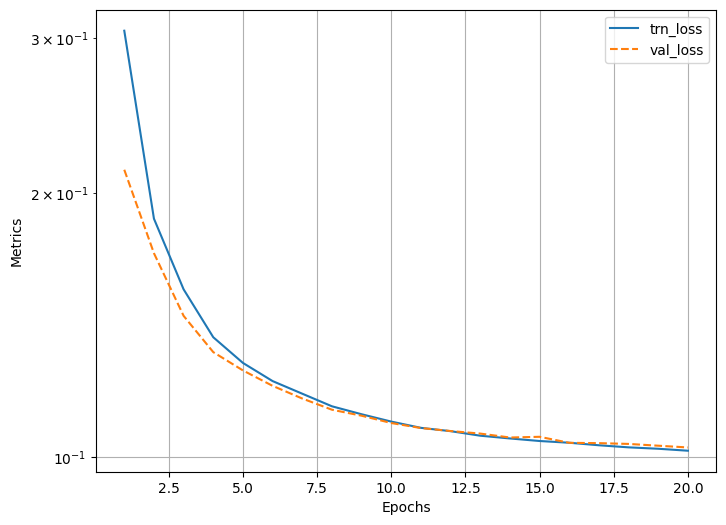

In [ ]:
log.plot_epochs(log=True)

In [ ]:
test_model(model, test_gaussian_dl, criterion)

Avg PSNR: 16.49
Avg SSIM: 0.6570


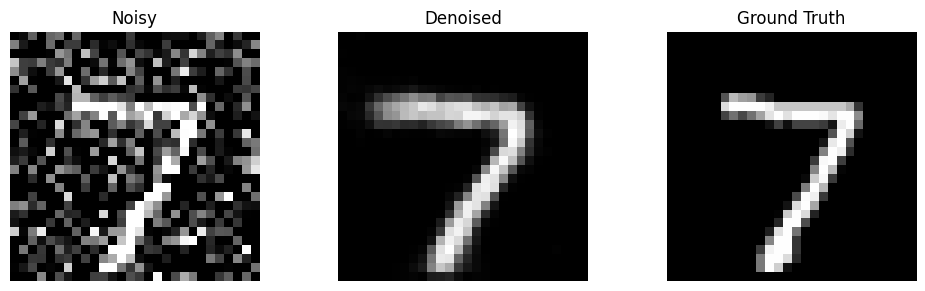

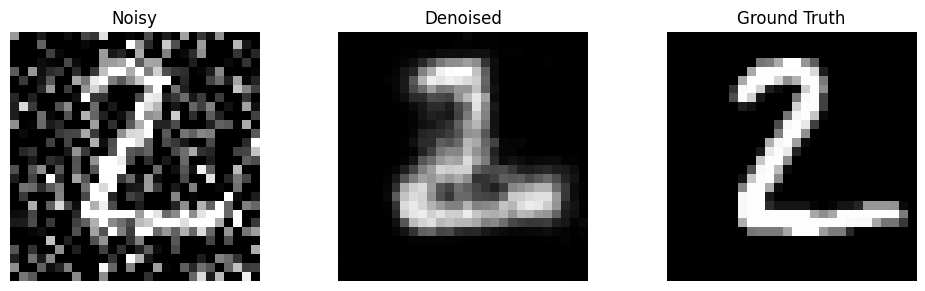

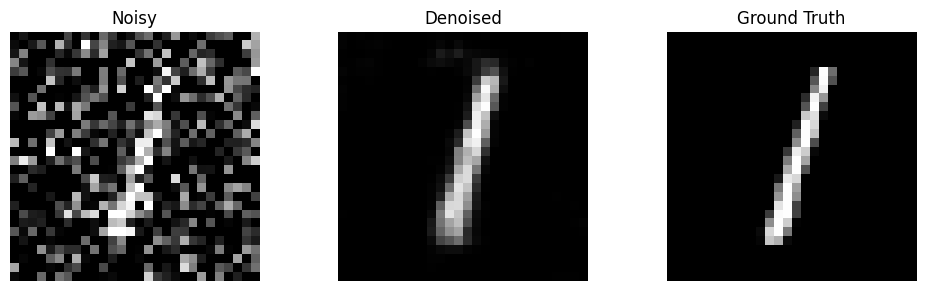

In [ ]:
visualize_denoising(model, test_gaussian_dl)

### Latent_dim = 4

In [ ]:
model = ConvAutoEncoder(latent_dim=4).to(device)

In [ ]:
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Flatten: 1-2                           [-1, 256]                 --
├─Linear: 1-3                            [-1, 4]                   1,028
├─Linear: 1-4                            [-1, 256]                 1,280
├─Unflatten: 1-5                         [-1, 64, 2, 2]            --
├─Sequential: 1-6                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464


In [ ]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [34]:
num_epochs = 20
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_gaussian_dl)
    for ix, (noisy, clean) in enumerate(trn_gaussian_dl):
        loss = train_batch(noisy, clean, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_gaussian_dl)
    for ix, (noisy, clean) in enumerate(val_gaussian_dl):
        loss = validate_batch(noisy,clean, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 0.301  val_loss: 0.205  (43.69s - 830.05s remaining)
EPOCH: 2.000  trn_loss: 0.176  val_loss: 0.156  (86.40s - 777.59s remaining)
EPOCH: 3.000  trn_loss: 0.144  val_loss: 0.136  (128.47s - 728.00s remaining)
EPOCH: 4.000  trn_loss: 0.131  val_loss: 0.127  (169.61s - 678.44s remaining)
EPOCH: 5.000  trn_loss: 0.122  val_loss: 0.119  (210.60s - 631.81s remaining)
EPOCH: 6.000  trn_loss: 0.116  val_loss: 0.114  (251.99s - 587.99s remaining)
EPOCH: 7.000  trn_loss: 0.113  val_loss: 0.113  (293.30s - 544.71s remaining)
EPOCH: 8.000  trn_loss: 0.110  val_loss: 0.110  (334.95s - 502.42s remaining)
EPOCH: 9.000  trn_loss: 0.109  val_loss: 0.108  (376.03s - 459.60s remaining)
EPOCH: 10.000  trn_loss: 0.107  val_loss: 0.108  (417.17s - 417.17s remaining)
EPOCH: 11.000  trn_loss: 0.106  val_loss: 0.106  (458.21s - 374.90s remaining)
EPOCH: 12.000  trn_loss: 0.105  val_loss: 0.105  (499.82s - 333.21s remaining)
EPOCH: 13.000  trn_loss: 0.104  val_loss: 0.105  (541.43s - 291

100%|██████████| 121/121 [00:00<00:00, 584.92it/s]


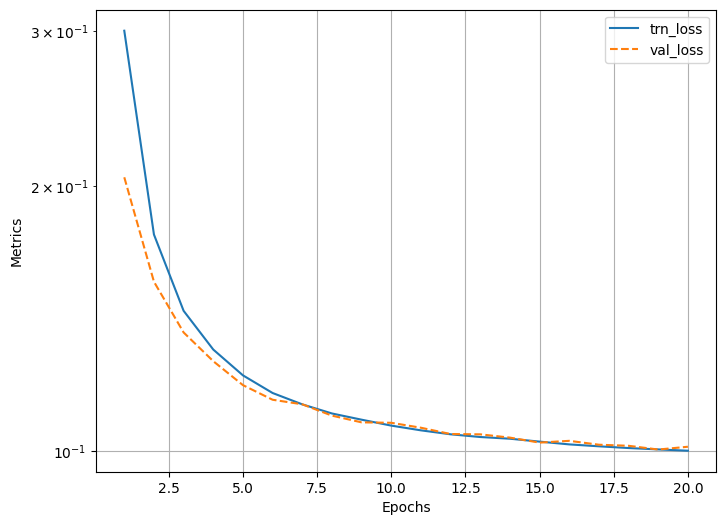

In [35]:
log.plot_epochs(log=True)

In [36]:
test_model(model, test_gaussian_dl, criterion)

Avg PSNR: 16.60
Avg SSIM: 0.6645


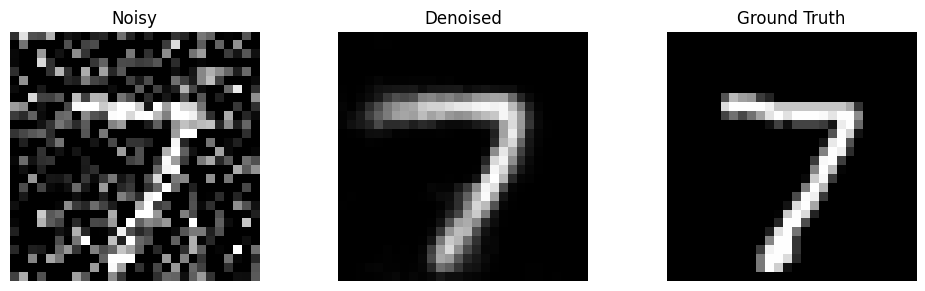

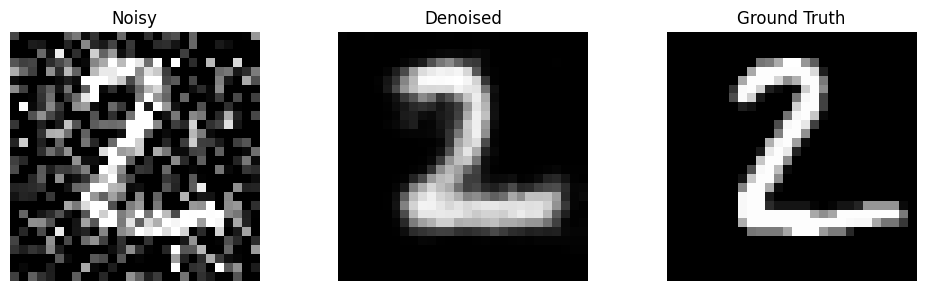

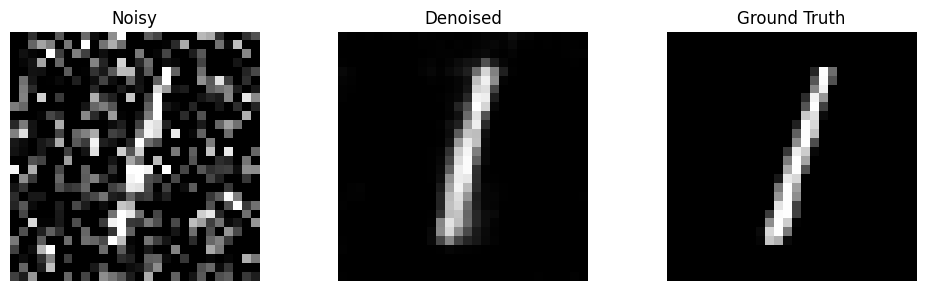

In [37]:
visualize_denoising(model, test_gaussian_dl)

## Salt and Pepper Noise

### Latent_dim = 16

In [16]:
model = ConvAutoEncoder(latent_dim=16).to(device)

In [17]:
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Flatten: 1-2                           [-1, 256]                 --
├─Linear: 1-3                            [-1, 16]                  4,112
├─Linear: 1-4                            [-1, 256]                 4,352
├─Unflatten: 1-5                         [-1, 64, 2, 2]            --
├─Sequential: 1-6                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464


#### Training

In [18]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
num_epochs = 20
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_sap_dl)
    for ix, (noisy, clean) in enumerate(trn_sap_dl):
        loss = train_batch(noisy, clean, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_sap_dl)
    for ix, (noisy, clean) in enumerate(val_sap_dl):
        loss = validate_batch(noisy,clean, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.223  trn_loss: 0.269  (73.67s - 1399.75s remaining)
EPOCH: 2.000  val_loss: 0.168  trn_loss: 0.185  (144.02s - 1296.15s remaining)
EPOCH: 3.000  val_loss: 0.153  trn_loss: 0.157  (215.16s - 1219.24s remaining)
EPOCH: 4.000  val_loss: 0.144  trn_loss: 0.148  (285.14s - 1140.57s remaining)
EPOCH: 5.000  val_loss: 0.140  trn_loss: 0.141  (355.72s - 1067.17s remaining)
EPOCH: 6.000  val_loss: 0.135  trn_loss: 0.136  (427.94s - 998.52s remaining)
EPOCH: 7.000  val_loss: 0.133  trn_loss: 0.133  (498.95s - 926.63s remaining)
EPOCH: 8.000  val_loss: 0.130  trn_loss: 0.130  (569.51s - 854.27s remaining)
EPOCH: 9.000  val_loss: 0.128  trn_loss: 0.128  (640.16s - 782.42s remaining)
EPOCH: 10.000  val_loss: 0.126  trn_loss: 0.126  (711.24s - 711.24s remaining)
EPOCH: 11.000  val_loss: 0.126  trn_loss: 0.125  (781.85s - 639.69s remaining)
EPOCH: 12.000  val_loss: 0.125  trn_loss: 0.124  (852.85s - 568.57s remaining)
EPOCH: 13.000  val_loss: 0.124  trn_loss: 0.123  (923.38s

100%|██████████| 121/121 [00:00<00:00, 604.38it/s]


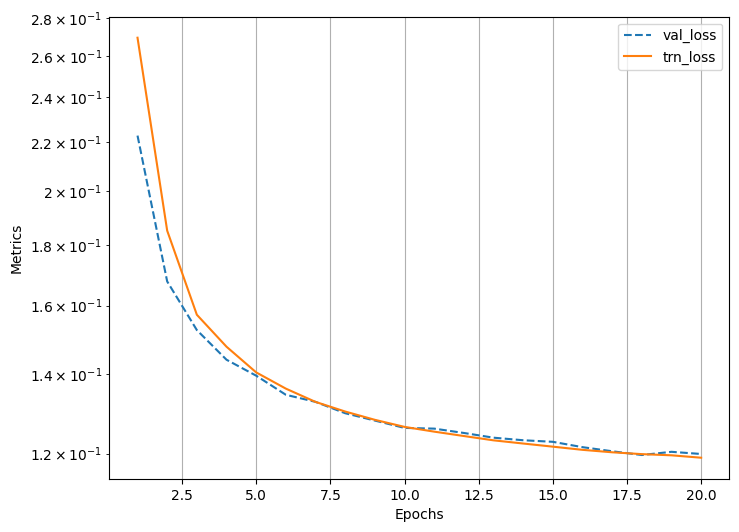

In [20]:
log.plot_epochs(log=True)

#### Testing

In [21]:
test_model(model, test_sap_dl, criterion)

Avg PSNR: 15.79
Avg SSIM: 0.6095


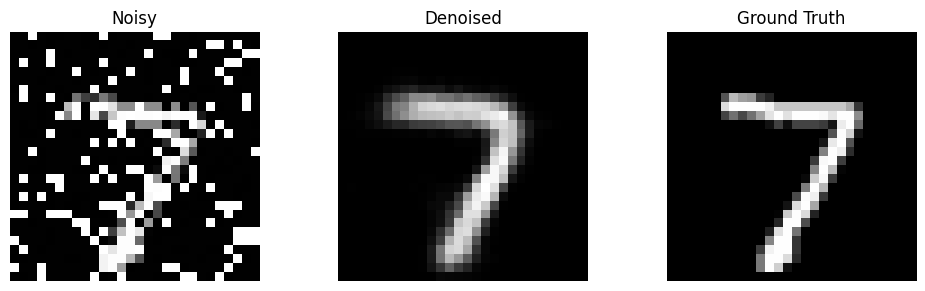

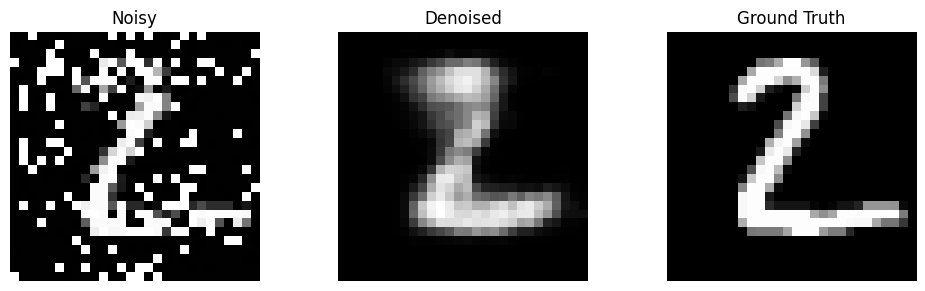

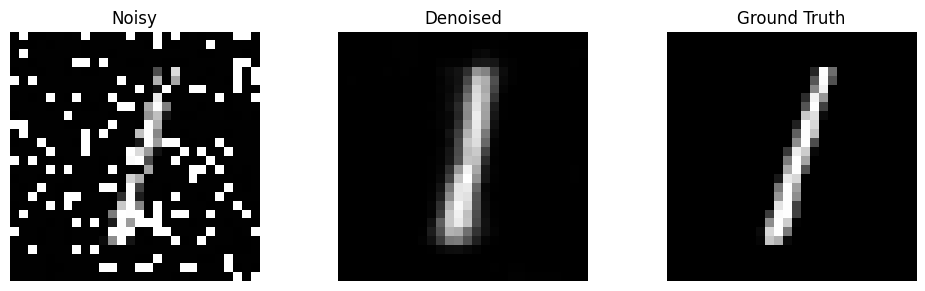

In [22]:
visualize_denoising(model, test_sap_dl)

### Latent_dim = 8

In [23]:
model = ConvAutoEncoder(latent_dim=8).to(device)

In [24]:
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Flatten: 1-2                           [-1, 256]                 --
├─Linear: 1-3                            [-1, 8]                   2,056
├─Linear: 1-4                            [-1, 256]                 2,304
├─Unflatten: 1-5                         [-1, 64, 2, 2]            --
├─Sequential: 1-6                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464


In [25]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [26]:
num_epochs = 20
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_sap_dl)
    for ix, (noisy, clean) in enumerate(trn_sap_dl):
        loss = train_batch(noisy, clean, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_sap_dl)
    for ix, (noisy, clean) in enumerate(val_sap_dl):
        loss = validate_batch(noisy,clean, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.243  trn_loss: 0.301  (71.41s - 1356.70s remaining)
EPOCH: 2.000  val_loss: 0.191  trn_loss: 0.215  (141.85s - 1276.61s remaining)
EPOCH: 3.000  val_loss: 0.164  trn_loss: 0.174  (213.41s - 1209.35s remaining)
EPOCH: 4.000  val_loss: 0.153  trn_loss: 0.157  (283.90s - 1135.62s remaining)
EPOCH: 5.000  val_loss: 0.144  trn_loss: 0.148  (355.48s - 1066.45s remaining)
EPOCH: 6.000  val_loss: 0.139  trn_loss: 0.142  (425.86s - 993.67s remaining)
EPOCH: 7.000  val_loss: 0.135  trn_loss: 0.137  (497.24s - 923.45s remaining)
EPOCH: 8.000  val_loss: 0.133  trn_loss: 0.133  (567.68s - 851.52s remaining)
EPOCH: 9.000  val_loss: 0.130  trn_loss: 0.131  (639.32s - 781.40s remaining)
EPOCH: 10.000  val_loss: 0.128  trn_loss: 0.128  (714.76s - 714.76s remaining)
EPOCH: 11.000  val_loss: 0.128  trn_loss: 0.127  (785.38s - 642.58s remaining)
EPOCH: 12.000  val_loss: 0.125  trn_loss: 0.125  (858.08s - 572.05s remaining)
EPOCH: 13.000  val_loss: 0.125  trn_loss: 0.124  (928.51s

100%|██████████| 121/121 [00:00<00:00, 605.65it/s]


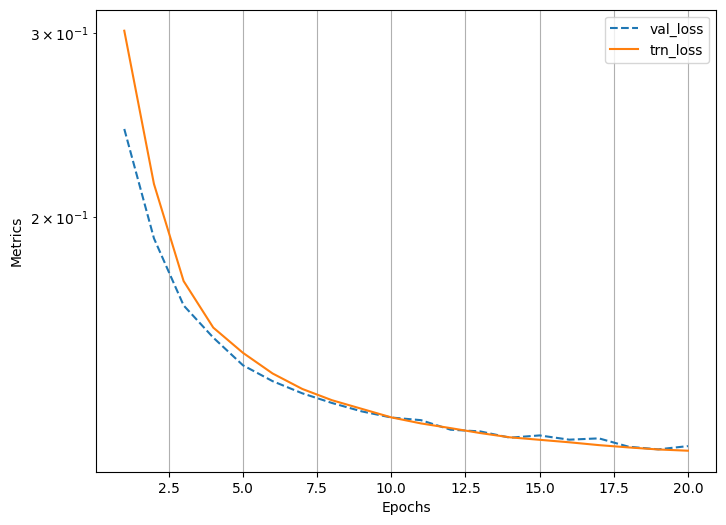

In [27]:
log.plot_epochs(log=True)

In [28]:
test_model(model, test_sap_dl, criterion)

Avg PSNR: 15.73
Avg SSIM: 0.6077


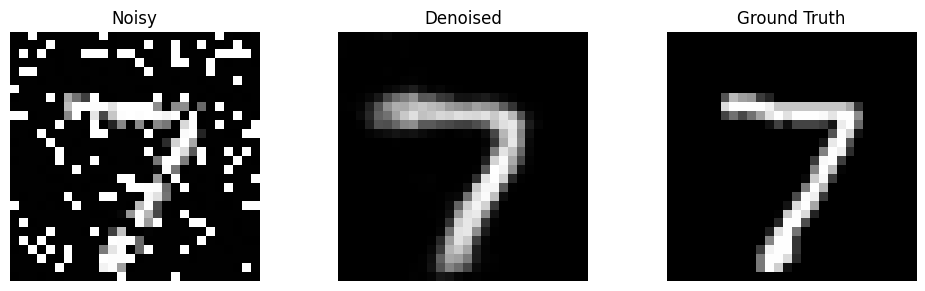

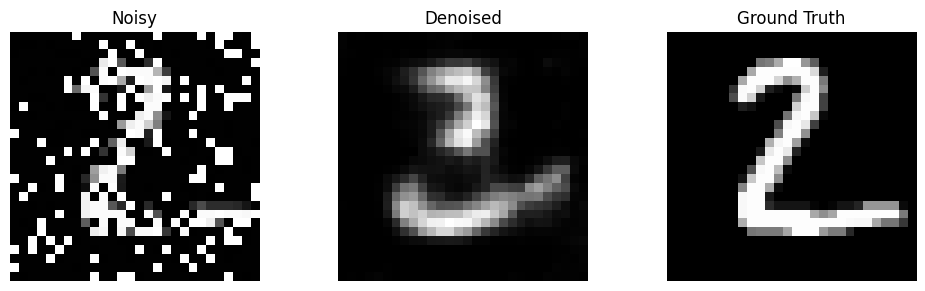

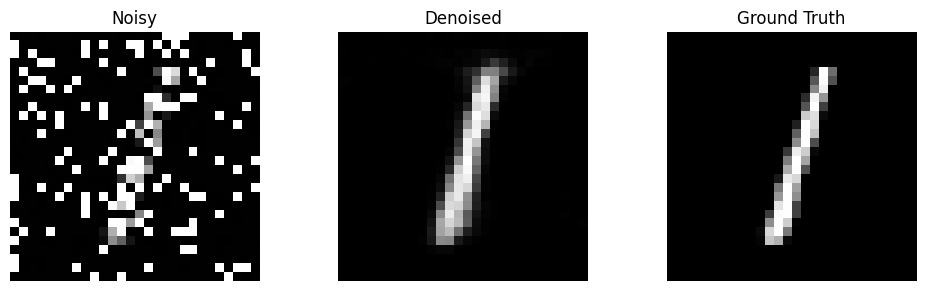

In [29]:
visualize_denoising(model, test_sap_dl)

### Latent_dim = 4

In [30]:
model = ConvAutoEncoder(latent_dim=4).to(device)

In [31]:
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Flatten: 1-2                           [-1, 256]                 --
├─Linear: 1-3                            [-1, 4]                   1,028
├─Linear: 1-4                            [-1, 256]                 1,280
├─Unflatten: 1-5                         [-1, 64, 2, 2]            --
├─Sequential: 1-6                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464


In [32]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [33]:
num_epochs = 20
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_sap_dl)
    for ix, (noisy, clean) in enumerate(trn_sap_dl):
        loss = train_batch(noisy, clean, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_sap_dl)
    for ix, (noisy, clean) in enumerate(val_sap_dl):
        loss = validate_batch(noisy,clean, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.243  trn_loss: 0.293  (71.12s - 1351.19s remaining)
EPOCH: 2.000  val_loss: 0.187  trn_loss: 0.209  (141.12s - 1270.07s remaining)
EPOCH: 3.000  val_loss: 0.160  trn_loss: 0.168  (212.32s - 1203.14s remaining)
EPOCH: 4.000  val_loss: 0.150  trn_loss: 0.154  (282.52s - 1130.08s remaining)
EPOCH: 5.000  val_loss: 0.144  trn_loss: 0.147  (354.06s - 1062.19s remaining)
EPOCH: 6.000  val_loss: 0.140  trn_loss: 0.142  (424.37s - 990.20s remaining)
EPOCH: 7.000  val_loss: 0.137  trn_loss: 0.138  (495.64s - 920.47s remaining)
EPOCH: 8.000  val_loss: 0.134  trn_loss: 0.135  (565.86s - 848.79s remaining)
EPOCH: 9.000  val_loss: 0.132  trn_loss: 0.132  (637.22s - 778.82s remaining)
EPOCH: 10.000  val_loss: 0.130  trn_loss: 0.130  (707.43s - 707.43s remaining)
EPOCH: 11.000  val_loss: 0.129  trn_loss: 0.129  (778.76s - 637.17s remaining)
EPOCH: 12.000  val_loss: 0.128  trn_loss: 0.128  (849.06s - 566.04s remaining)
EPOCH: 13.000  val_loss: 0.127  trn_loss: 0.126  (920.51s

100%|██████████| 121/121 [00:00<00:00, 618.46it/s]


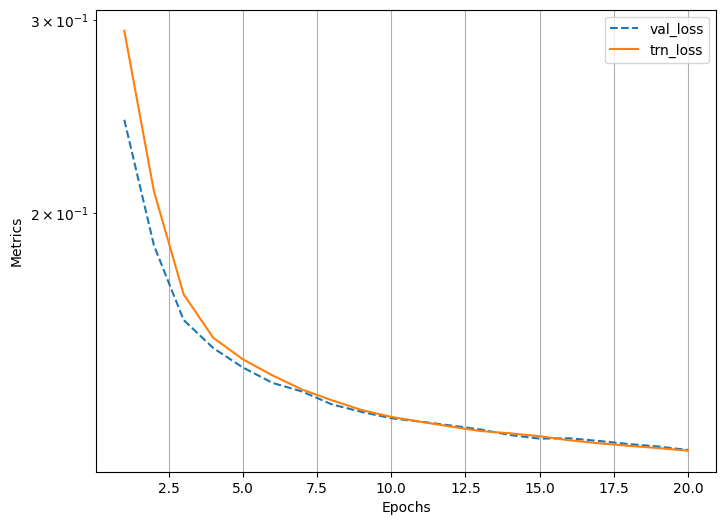

In [34]:
log.plot_epochs(log=True)

In [35]:
test_model(model, test_sap_dl, criterion)

Avg PSNR: 15.70
Avg SSIM: 0.6011


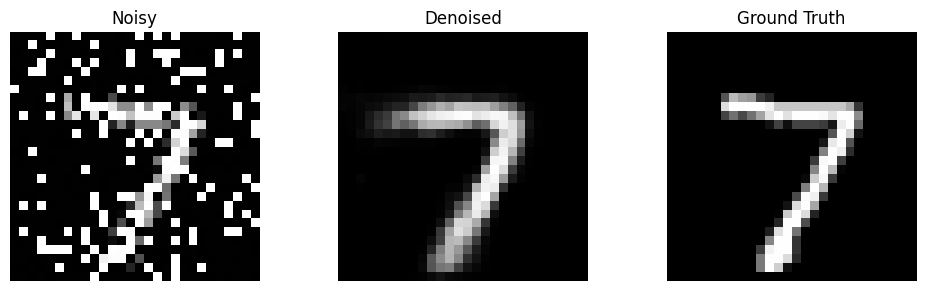

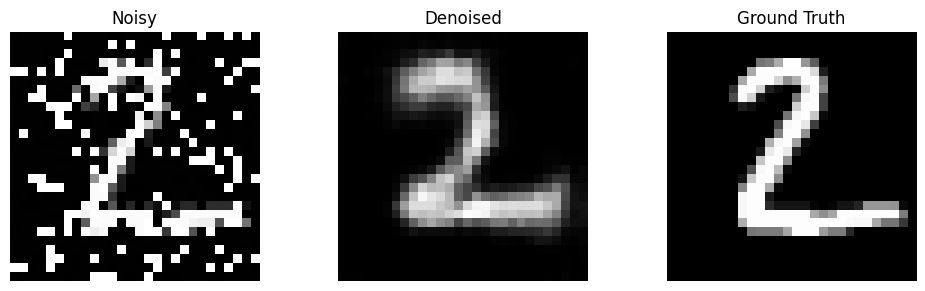

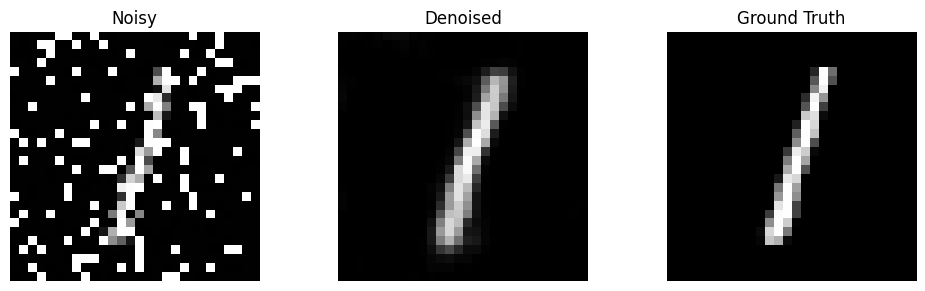

In [36]:
visualize_denoising(model, test_sap_dl)